In [49]:
'''
Create scatterplots for each flight date using the example database derived from
Fukushima data on data.gov.

This Notebook demonstrates using Sina queries to display the data in scatterplots.

Data source: https://catalog.data.gov/dataset/\
    us-doe-nnsa-response-to-2011-fukushima-incident-at-sea-aerial-data
'''
import json
import ipywidgets as widgets
import IPython.display as ipyd
import sys

# TODO: Change the path below to your sina installation if the following doesn't work for you.
sys.path.append('/collab/usr/gapps/wf/releases/venv-user/lib/python2.7/site-packages/sina')

import sina.datastores.sql as sds
import sina.datastores.sql_schema as sdss

# Create the database access factory.
# (NOTE:  The following data is currently only available on the CZ.)
#fact = sds.DAOFactory('/usr/gapps/wf/examples/data/fukushima/fukushima.sqlite')
fact = sds.DAOFactory('/g/g21/dahlgren/siboka/examples/fukushima/files/fukushima.sqlite')

In [60]:
# Extract the data from the database
lobs = fact.createRecordDAO().get_all_of_type("obs")

# Build a list of table entries, one observation per table row
# .. Hard-coding units in the heading instead of extracting from data
ldata = [
    ['Date', 'Latitude (degrees)', 'Longitude (degrees)', 'Counts Per Second']
]

keys = ['date', 'latitude', 'longitude', 'gcnorm']
data = {}
for obs in lobs:
    rec = json.loads(obs.raw)
    lvals = ['' for _ in lkeys]
    for row in json.loads(obs.raw)['data']:
        nm = row['name']
        lkys = row.keys()
        if nm in lkeys:
            ind = lkeys.index(nm)
            val = row['value']
            if isinstance(val, unicode):
                val = val.encode('utf-8')
            if nm != 'date':
                val = float(val)
            lvals[ind] = val
    dt, lat, lon, gcnorm = lvals
    coords = (lon, lat)
    if dt in data.keys():
        if coords in data[dt].keys():
            data[dt][coords].append(val)
        else:
            data[dt][coords] = [val]
    else:
        data[dt] = {coords: [val]}

In [83]:
# Perform basic plotting set up: imports and colors
import matplotlib.pyplot as plt
import numpy as np

cities = [  # (lon, lat), desc, horiza
    [(141.0281, 37.4213), ' Daiichi Nuclear Power Plant', 'left'],
    [(141.0125, 37.4492), 'Futaba ', 'right'],
    [(141.0000, 37.4833), ' Namie', 'left'],
    [(140.9836, 37.4044), ' Okuma', 'left'],
    [(141.0088, 37.3454), ' Tomioka', 'left']]

colors = [['black', (0,0)],
          ['blue', (0, 2000)],
          ['cyan', (2000, 3000)],
          ['green', (3000, 5000)],
          ['yellow', (5000, 10000)],
          ['orange', (10000, 20000)],
          ['red', (20000, 9999999)]]

def getcolor(val):
    col = 'black'
    for cl, rng in colors:
        if val >= rng[0] and val < rng[1]:
            col = cl
            break
    return col


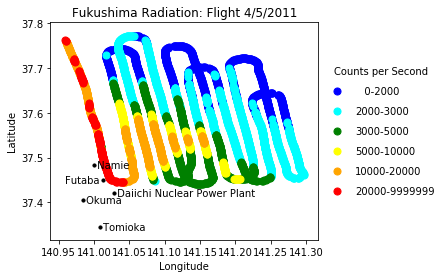

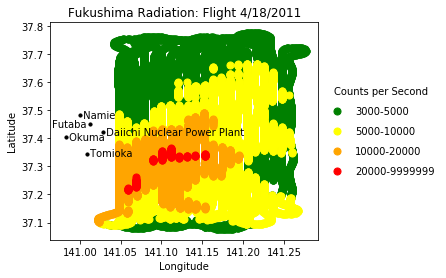

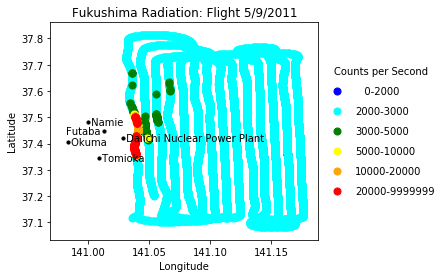

In [84]:
# Define the plotting function
def plotdate(dt):
    # Aggregate the data by color
    vals = {}
    for col, rng in colors:
        vals[col] = []
        
    for coord, _, _ in cities:
        vals['black'].append(list(coord))
    
    ddata = data[dt]
    for coords in ddata.keys():
        maxgc = max(ddata[coords])
        vals[getcolor(maxgc)].append(list(coords))
    
    # Now produce the plot
    fig = plt.figure()
    ax = plt.subplot(111)
    plt.title("Fukushima Radiation: Flight %s" % dt)
    plt.xlabel('Longitude')
    plt.ylabel('Latitude')

    for cl, rng in colors:
        nvals = len(vals[cl])
        if nvals > 0:
            arr = np.array(vals[cl])
            if cl == 'black':
                lbl = None
                area = 10
            else:
                lbl = '%4d-%4d' % rng
                area = 50
            plt.scatter(x=arr[:,0], y=arr[:,1], s=area,
                        c=cl,label=lbl)
    
    for coord, desc, horiza in cities:
        ax.annotate(desc, coord, va="center", ha=horiza)
    
    box = ax.get_position()
    ax.set_position([box.x0, box.y0, box.width*0.8, box.height])
    ax.legend(scatterpoints=1, frameon=False, labelspacing=1,
              loc='center left', bbox_to_anchor=(1, 0.5), title='Counts per Second')
    
    plt.show()
    
# Plot the data
for dt in ['4/5/2011', '4/18/2011', '5/9/2011']:
    plotdate(dt)